In [1]:
using LaTeXStrings, Plots, Markdown, Distributions, MonteCarloMeasurements, Printf
gr()


(process:17684): GLib-GIO-WARNING **: 14:38:16.509: Unexpectedly, UWP app `Evernote.Evernote_10.30.6.0_x86__q4d96b2w5wcc2' (AUMId `Evernote.Evernote_q4d96b2w5wcc2!Evernote') supports 1 extensions but has no verbs


Plots.GRBackend()

In [2]:
println("BGK Equation")
println("Consider a single species with a constant collisional frequency")
L"""\left(\dfrac{\partial f_s}{\partial t} \right)_{collisions} \
    = \
    v_{ss}(F_s - f_s) \ """

#= Reference: 
Eq. (26)
Bradshaw, S.J., Raymond, J. Collisional and Radiative Processes in Optically Thin Plasmas. Space Sci Rev 178, 271–306 (2013). 
https://doi.org/10.1007/s11214-013-9970-0
=#

BGK Equation
Consider a single species with a constant collisional frequency


L"$\left(\dfrac{\partial f_s}{\partial t} \right)_{collisions} \
= \
v_{ss}(F_s - f_s) \ $"

In [7]:
# Initially comparing chosen distribution f_s to Maxwellian F_s

velᵤ = -0.1:0.005:4
f_s0 = pdf.(Uniform(0,1), velᵤ) # uniform distribution with area 1
plot(velᵤ, f_s0, label=L"f_{s}" * " at t=0 s", framestyle=:box)

velᵪ = 0:0.005:4
F_s = pdf.(Chi(3), velᵪ)  # chi distribution with area 1

plot!(velᵪ, F_s, linecolor = :orange, linestyle = :dash, label= L"F_s" * " (Maxwellian)")
xlabel!("velocity")
ylabel!("probability density")
xlims!(-0.1, 4)
ylims!(0, 1.5)
savefig("BGK_initial.png")

┌ Info: Saved animation to 
│   fn = C:\Users\Acer\Documents\Julia\Simple-BGK-Model\Simple_BGK_Explicit.gif
└ @ Plots C:\Users\Acer\.julia\packages\Plots\Zuo5g\src\animation.jl:114
┌ Info: Saved animation to 
│   fn = C:\Users\Acer\Documents\Julia\Simple-BGK-Model\Simple_BGK_Implicit.gif
└ @ Plots C:\Users\Acer\.julia\packages\Plots\Zuo5g\src\animation.jl:114
┌ Info: Saved animation to 
│   fn = C:\Users\Acer\Documents\Julia\Simple-BGK-Model\Simple_BGK_Both.gif
└ @ Plots C:\Users\Acer\.julia\packages\Plots\Zuo5g\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\Acer\\Documents\\Julia\\Simple-BGK-Model\\Simple_BGK_Both.gif")
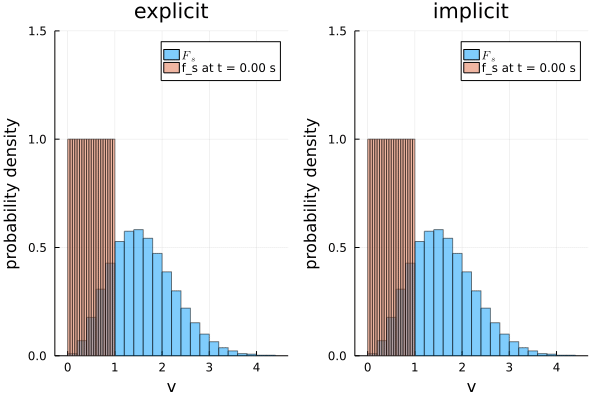

In [6]:
default(alpha=0.5, nbins=20, normalize=true) # set plot defaults

v_col = 1

dt = 10^(-5) # timestep
t = range(0, 3.0, step=dt)

f_s0 = Particles(Uniform(0,1))
f_s_exp = [f_s0] # explicit method
f_s_imp = [f_s0] # implicit method
F_s = Particles(Chi(3))

for it in 1:length(t)-1
    push!(f_s_exp, dt*v_col*(F_s - f_s_exp[it]) + f_s_exp[it])
    push!(f_s_imp, (f_s_imp[it] + v_col*F_s*dt)/(1 + v_col*dt))
end

anim_exp = @animate for i in 1:1000:length(t)
           plot(F_s; label=L"F_s")
           plot!(f_s_exp[i]; label=@sprintf("f_s at t = %.2f s", t[i]), ylims=(0.0,1.5))
           xlabel!("v")
           ylabel!("probability density")
           title!("Simple BGK Model (explicit method)")
       end;

gif(anim_exp, "Simple_BGK_Explicit.gif"; fps=10)

anim_imp = @animate for i in 1:1000:length(t)
           plot(F_s; label=L"F_s")
           plot!(f_s_imp[i]; label=@sprintf("f_s at t = %.2f s", t[i]), ylims=(0.0,1.5))
           xlabel!("v")
           ylabel!("probability density")
           title!("Simple BGK Model (implicit method)")
       end;

gif(anim_imp, "Simple_BGK_Implicit.gif"; fps=10)

anim_both = @animate for i in 1:1000:length(t)
           a = plot(F_s; label=L"F_s")
           a = plot!(f_s_exp[i]; label=@sprintf("f_s at t = %.2f s", t[i]), ylims=(0.0,1.5))
           a = title!("explicit")
           b = plot(F_s; label=L"F_s")
           b = plot!(f_s_imp[i]; label=@sprintf("f_s at t = %.2f s", t[i]), ylims=(0.0,1.5))
           b = title!("implicit")
           plot(a, b, layout = (1, 2), legend = true)
           xlabel!("v")
           ylabel!("probability density")
            
       end;

gif(anim_both, "Simple_BGK_Both.gif"; fps=10)
